In [34]:
import subprocess
import os
import sys

import matplotlib.backends.backend_pdf
import scanpy as sc
import matplotlib.pyplot as pl
import anndata as ad
import pandas as pd
import numpy as np
import seaborn as sns
import scvelo as scv
scv.settings.verbosity=1

# Jupyter stuff
from tqdm.notebook import tqdm
from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline

# Custom functions
sys.path.insert(1, '../..')
from utils import *

Wikipedia:
>The intrinsic dimension for a data set can be thought of as the number of variables needed in a minimal representation of the data. Similarly, in signal processing of multidimensional signals, the intrinsic dimension of the signal describes how many variables are needed to generate a good approximation of the signal.
When estimating intrinsic dimension, however, a slightly broader definition based on manifold dimension is often used, where a representation in the intrinsic dimension does only need to exist locally. Such intrinsic dimension estimation methods can thus handle data sets with different intrinsic dimensions in different parts of the data set. This is often referred to as local intrinsic dimensionality.
The intrinsic dimension can be used as a lower bound of what dimension it is possible to compress a data set into through dimension reduction, but it can also be used as a measure of the complexity of the data set or signal. For a data set or signal of N variables, its intrinsic dimension M satisfies 0 ≤ M ≤ N, although estimators may yield higher values.

We can define the intrinsic dimension as:
- the number of latent dimensions necessary to explain / conserve / describe a set minimum amount of variability in the data.
- the amount of variability explained / conserved / described in the data by a set number of maximum latent variables.

PCA pro and contra:
- pro: deterministic
- pro: unbiased / we do not need to select a set of parameters or similar
- pro: PCA is fast
- pro: In many cases PCA is the input for other methods itself. So if dimensionality is not conserved in PCA is will be missed by e.g. a UMAP anyways
- contra: if data is very efficiently described by a single nonlinearity, linear PCA might need multiple dimensions more than necessary

In [35]:
import sys
sys.path.insert(1, '/fast/work/users/peidlis_c/utils/single_cell_rna_seq/scrnaseq_utils/')
# sys.path.insert(1, '/extra/stefan/utils/scrnaseq_utils/')
from scrnaseq_util_functions import *

In [36]:
path = '/fast/work/users/peidlis_c/data/perturbation_resource_paper/'
folders = get_subfolders(path, False)
folders

['PapalexiSatija2021',
 'TianKampmann2021',
 'XieHon2017',
 'AissaBenevolenskaya2021',
 'McFarlandTshemiak2020',
 'GasperiniShendure2019',
 'ZhaoSims2021',
 'DixitRegev2016',
 'DatlingerBock2017',
 'FrangiehIzar2021',
 'WeinrebKlein2020',
 'ShifrutMarson2018',
 'ChangYe2021',
 'JaitinAmit2016',
 'SchiebingerLander2019',
 'NormanWeissman2019',
 'SchraivogelSteinmetz2020',
 'AdamsonWeissman2016',
 'SrivatsanTrapnell2020',
 'exampledataset',
 'OrenRegev2021',
 'TianKampmann2019']

# Across datasets

In [54]:
# takes long
results = {}
for file in tqdm(files):
    adata = sc.read(f'{path}{file}')
    sc.pp.pca(adata, n_comps=100)
    results[file[:-3]] = np.array([0] + list(np.cumsum(adata.uns['pca']['variance_ratio'])))
    df = pd.DataFrame(results)
    df.to_csv('intrinsic_dimension_data.csv')

  0%|          | 0/16 [00:00<?, ?it/s]

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [6]:
df = pd.read_csv('intrinsic_dimension_data.csv', index_col=0)

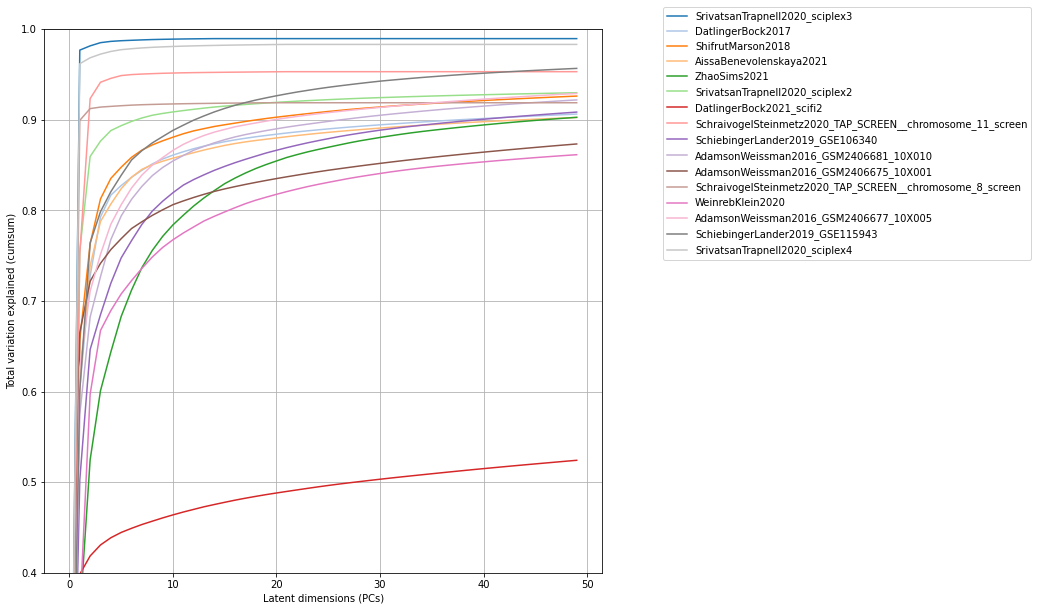

In [7]:
cmap = get_cmap('tab20')
n = 50 # 101
pl.figure(figsize=[10,10])
for i, column in enumerate(df.columns):
    pl.plot(np.arange(n), df[column][:n], label=column, c=cmap(i))
pl.grid()
pl.xlabel('Latent dimensions (PCs)')
pl.ylabel('Total variation explained (cumsum)')
pl.legend(bbox_to_anchor=(1.1, 1.05))
pl.ylim([0.4, 1])
pl.show()

In [8]:
# 2 mins
files = sorted(get_files(path, False))
adatas = {}
for file in tqdm(files):
    adata = sc.read(path+file)
    calc_qc(adata)
    adatas[file[:-3]] = adata

 31%|██████████████████████████████████████▍                                                                                    | 5/16 [00:17<00:36,  3.30s/it]

Could not reliably detect organism from mito genes. Setting as human.


 50%|█████████████████████████████████████████████████████████████▌                                                             | 8/16 [01:02<01:54, 14.37s/it]

Could not reliably detect organism from mito genes. Setting as human.


 56%|█████████████████████████████████████████████████████████████████████▏                                                     | 9/16 [01:02<01:10, 10.09s/it]

Could not reliably detect organism from mito genes. Setting as human.


 75%|███████████████████████████████████████████████████████████████████████████████████████████▌                              | 12/16 [01:11<00:21,  5.33s/it]

Could not reliably detect organism from mito genes. Setting as human.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [02:14<00:00,  8.41s/it]


In [9]:
cat_obs_keys = ['perturbation_type', 'organism', 'tissue_type', 'cell_line', 'cancer', 'disease', 'celltype']  # cat vector with a single value (ideally)

In [10]:
B=pd.DataFrame({dkey: [list(pd.unique(adatas[dkey].obs[key]))[0] if key in adatas[dkey].obs.keys() else None for key in cat_obs_keys] for dkey in adatas.keys()}, index=cat_obs_keys).T

In [11]:
vals={}
for dkey in adatas.keys():
    adata = adatas[dkey]
    vals[dkey] = [adata.n_vars, adata.n_obs, np.mean(adata.obs.ncounts), np.mean(adata.obs.ngenes)]
C = pd.DataFrame(vals, index=['Number of features', 'Number of cells', 'Mean number of counts', 'Mean number of genes expressed']).T

In [35]:
D = pd.concat([B,C], axis=1)
D['n_perturbations'] = None
for key in adatas.keys():
    try:
        x=len(pd.unique(adatas[key].obs.perturbation))
    except:
        x=1
    D.loc[key, 'n_perturbations'] = x
D

,perturbation_type,organism,tissue_type,cell_line,cancer,disease,celltype,Number of features,Number of cells,Mean number of counts,Mean number of genes expressed,n_perturbations
AdamsonWeissman2016_GSM2406675_10X001,CRISPR,human,cell_line,K562,True,chronic myelogenous leukemia,lymphoblasts,35635.0,5768.0,10166.141602,2557.463592,10
AdamsonWeissman2016_GSM2406677_10X005,CRISPR,human,cell_line,K562,True,chronic myelogenous leukemia,lymphoblasts,32738.0,15006.0,25340.050781,4235.199187,21
AdamsonWeissman2016_GSM2406681_10X010,CRISPR,human,cell_line,K562,True,chronic myelogenous leukemia,lymphoblasts,32738.0,65337.0,15915.297852,3639.789813,115
AissaBenevolenskaya2021,drug,human,cell_line,M14,True,melanoma,melanocytes,11644.0,230553.0,416.994904,220.417388,1
DatlingerBock2017,CRISPR,human,cell_line,Jurkat cells,True,acute T cell leukemia,T cells,36722.0,5905.0,8567.240234,2789.345470,97
DatlingerBock2021_scifi2,CRISPR,human,cell_line,Jurkat cells,True,acute T cell leukemia,T cells,25904.0,39194.0,957.881409,273.351508,48
SchiebingerLander2019_GSE106340,None,None,None,None,None,None,None,27998.0,68339.0,8259.157227,2383.194867,1
SchiebingerLander2019_GSE115943,None,None,None,None,None,None,None,27998.0,259155.0,13433.578125,2704.406525,1
SchraivogelSteinmetz2020_TAP_SCREEN__chromosome_11_screen,CRISPR,human,cell_line,K562,True,chronic myelogenous leukemia,lymphoblasts,3185.0,120310.0,1725.675903,60.285346,3105
SchraivogelSteinmetz2020_TAP_SCREEN__chromosome_8_screen,CRISPR,human,cell_line,K562,True,chronic myelogenous leukemia,lymphoblasts,4191.0,112260.0,1445.199951,61.168546,4115


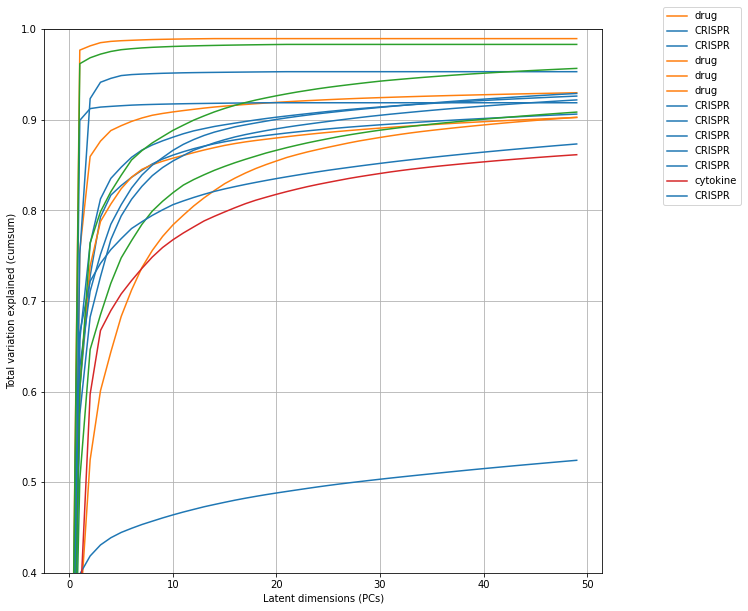

In [31]:
groupby = 'perturbation_type'
groups = pd.unique(D[groupby])
cdict={group: get_cmap('tab10')(i) for i, group in enumerate(groups)}
n = 50 # 101
pl.figure(figsize=[10,10])
for i, column in enumerate(df.columns):
    group=D.loc[column][groupby]
    pl.plot(np.arange(n), df[column][:n], label=group, c=cdict[group])
pl.grid()
pl.xlabel('Latent dimensions (PCs)')
pl.ylabel('Total variation explained (cumsum)')
pl.legend(bbox_to_anchor=(1.1, 1.05))
pl.ylim([0.4, 1])
pl.show()

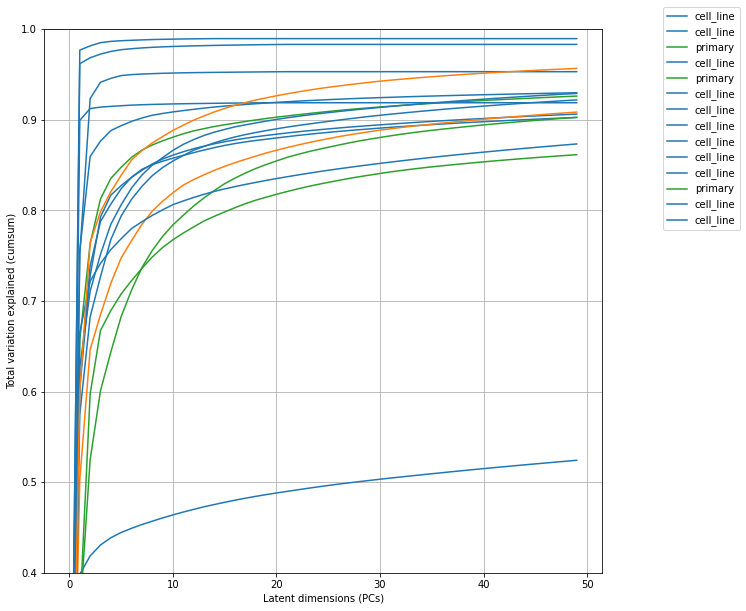

In [32]:
groupby = 'tissue_type'
groups = pd.unique(D[groupby])
cdict={group: get_cmap('tab10')(i) for i, group in enumerate(groups)}
n = 50 # 101
pl.figure(figsize=[10,10])
for i, column in enumerate(df.columns):
    group=D.loc[column][groupby]
    pl.plot(np.arange(n), df[column][:n], label=group, c=cdict[group])
pl.grid()
pl.xlabel('Latent dimensions (PCs)')
pl.ylabel('Total variation explained (cumsum)')
pl.legend(bbox_to_anchor=(1.1, 1.05))
pl.ylim([0.4, 1])
pl.show()

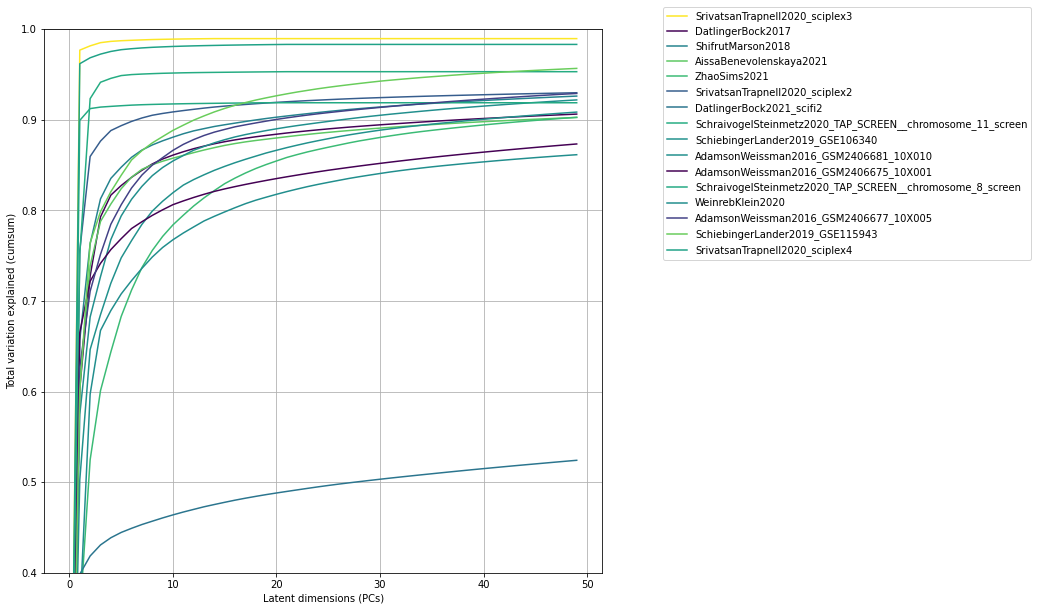

In [20]:
groupby = 'Number of cells'
n = 50 # 101
cmap = get_cmap('viridis')
c = np.log(D[groupby])
cmax = np.max(c)
cmin = np.min(c)
pl.figure(figsize=[10,10])
for i, column in enumerate(df.columns):
    group=c.loc[column]
    x = (group-cmin)/(cmax-cmin)
    pl.plot(np.arange(n), df[column][:n], label=column, c=cmap(x))
pl.grid()
pl.xlabel('Latent dimensions (PCs)')
pl.ylabel('Total variation explained (cumsum)')
pl.legend(bbox_to_anchor=(1.1, 1.05))
pl.ylim([0.4, 1])
pl.show()

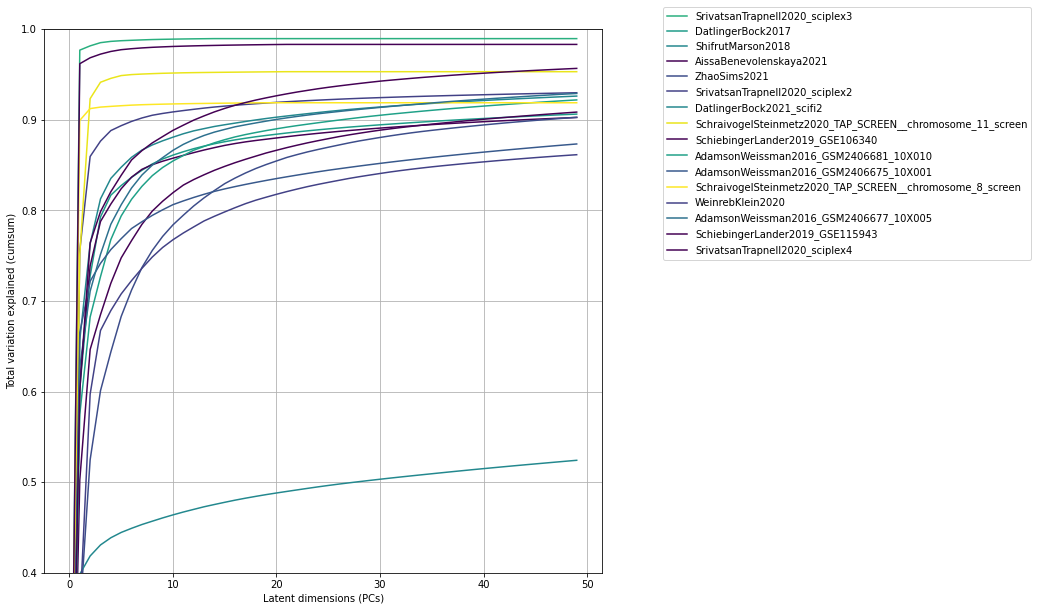

In [38]:
groupby = 'n_perturbations'
n = 50 # 101
cmap = get_cmap('viridis')
c = np.log(D[groupby].astype(float))
cmax = np.max(c)
cmin = np.min(c)
pl.figure(figsize=[10,10])
for i, column in enumerate(df.columns):
    group=c.loc[column]
    x = (group-cmin)/(cmax-cmin)
    pl.plot(np.arange(n), df[column][:n], label=column, c=cmap(x))
pl.grid()
pl.xlabel('Latent dimensions (PCs)')
pl.ylabel('Total variation explained (cumsum)')
pl.legend(bbox_to_anchor=(1.1, 1.05))
pl.ylim([0.4, 1])
pl.show()

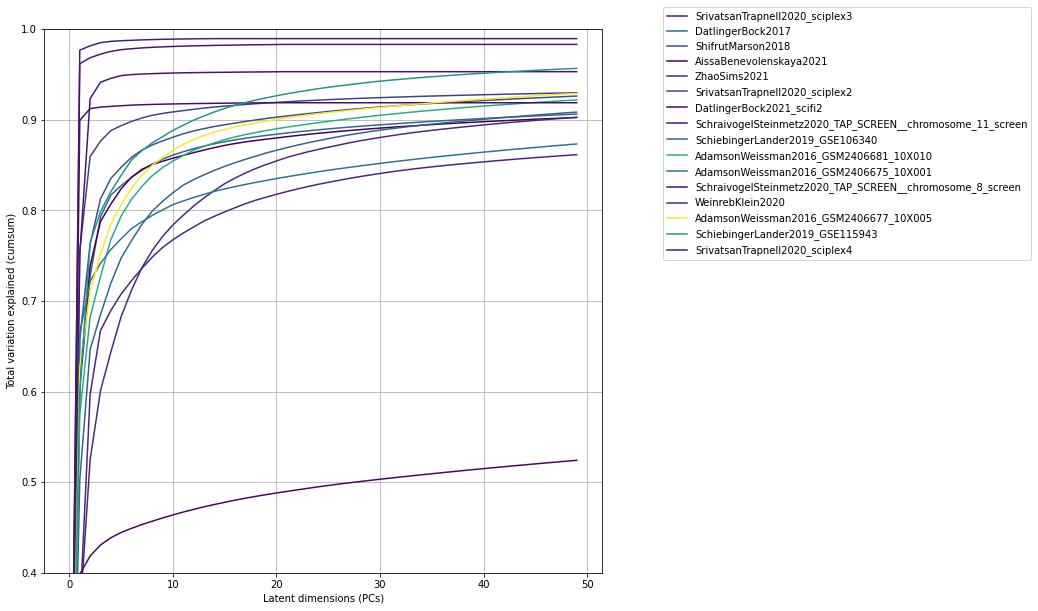

In [128]:
groupby = 'Mean number of counts'
n = 50 # 101
cmap = get_cmap('viridis')
cmax = np.max(D[groupby])
cmin = np.min(D[groupby])
pl.figure(figsize=[10,10])
for i, column in enumerate(df.columns):
    group=D.loc[column][groupby]
    x = (group-cmin)/(cmax-cmin)
    pl.plot(np.arange(n), df[column][:n], label=column, c=cmap(x))
pl.grid()
pl.xlabel('Latent dimensions (PCs)')
pl.ylabel('Total variation explained (cumsum)')
pl.legend(bbox_to_anchor=(1.1, 1.05))
pl.ylim([0.4, 1])
pl.show()

# Single dataset

## ZhaoSims2021

In [21]:
adata = read_from_singles(f'{path}ZhaoSims2021')

# subsample to same class sizes
adata = equal_subsampling(adata, 'perturbation')
adata.obs.perturbation.value_counts()

Ana-12          2683
RO4929097       2683
Tazemetostat    2683
control         2683
etoposide       2683
panobinostat    2683
Ispenisib       2682
Name: perturbation, dtype: int64

In [119]:
n_comps=100
n_cells = np.floor(N/2)
css = {}
for p in tqdm(pd.unique(adata.obs.perturbation), leave=False):
    n_cells = int(np.floor(N/2)) if p!='control' else N
    selection = np.ravel(np.array([np.random.choice(adata.obs_names[adata.obs.perturbation==p], size=n_cells, replace=False) for p in pd.unique(['control', p])]))
    cdata = adata[selection].copy()
    print(p, cdata.n_obs)
    sc.pp.pca(cdata, n_comps=n_comps)
    css[p] = np.array([0] + list(np.cumsum(cdata.uns['pca']['variance_ratio'])))
df = pd.DataFrame(css)
df.head()

  0%|          | 0/7 [00:00<?, ?it/s]

panobinostat 2682


 14%|█▍        | 1/7 [00:15<01:32, 15.43s/it]

control 2683


 29%|██▊       | 2/7 [00:29<01:12, 14.43s/it]

etoposide 2682


 43%|████▎     | 3/7 [00:49<01:08, 17.02s/it]

Ana-12 2682


 57%|█████▋    | 4/7 [01:00<00:43, 14.66s/it]

RO4929097 2682


 71%|███████▏  | 5/7 [01:18<00:31, 15.96s/it]

Tazemetostat 2682


 86%|████████▌ | 6/7 [01:31<00:14, 14.81s/it]

Ispenisib 2682


,panobinostat,control,etoposide,Ana-12,RO4929097,Tazemetostat,Ispenisib
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.400802,0.412722,0.346374,0.405702,0.358576,0.369694,0.417200
2,0.522274,0.602442,0.527981,0.614803,0.596393,0.565467,0.626746
3,0.596531,0.669839,0.602556,0.691734,0.661816,0.650725,0.687028
4,0.656448,0.717818,0.646502,0.739650,0.720209,0.709627,0.731009


In [120]:
# complexity score
from scipy.integrate import simps
areas = {}
for p in tqdm(pd.unique(adata.obs.perturbation), leave=False):
    areas[p] = 1-simps(df[p]) / (n_comps+1)
ar = pd.Series(areas).sort_values(ascending=False)

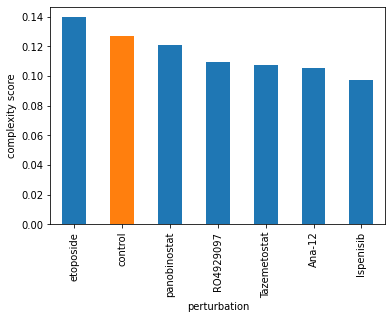

In [121]:
ar.plot.bar(color=['tab:orange' if c=='control' else 'tab:blue' for c in ar.index])
pl.ylabel('complexity score')
pl.xlabel('perturbation')
pl.show()

## ShifrutMarson2018

In [22]:
adata = read_from_singles(f"{path}ShifrutMarson2018")
# high class imbalance
adata.obs.perturbation.value_counts()

control                      27142
ES.sg15.DGKA                  1383
ES.sg2.BTLA                   1215
ES.sg26.PDCD1                 1111
ES.sg43.NonTarget.CTRL108     1092
ES.sg14.DGKA                   913
ES.sg19.HAVCR2                 859
ES.sg16.DGKZ                   852
ES.sg4.C10orf54                811
ES.sg28.RASA2                  728
ES.sg37.TMEM222                724
ES.sg7.CBLB                    718
ES.sg36.TMEM222                702
ES.sg22.LCP2                   671
ES.sg6.CBLB                    609
ES.sg10.CD5                    599
ES.sg0.ARID1A                  586
ES.sg21.LAG3                   582
ES.sg35.TCEB2                  577
ES.sg39.TNFRSF9                561
ES.sg24.MEF2D                  558
ES.sg30.SOCS1                  500
ES.sg18.HAVCR2                 496
ES.sg11.CD5                    481
ES.sg25.MEF2D                  468
ES.sg45.NonTarget.CTRL232      465
ES.sg47.NonTarget.CTRL241      449
ES.sg8.CD3D                    439
ES.sg13.CDKN1B      

In [23]:
# ~13secs
sc.pp.filter_cells(adata, min_counts=1000)
sc.pp.filter_genes(adata, min_cells=50)
N = 300

adata = equal_subsampling(adata, 'perturbation', N)

sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)

In [25]:
df = estimate_intrinsic_dimension_per_group(adata, 'perturbation', N, 30)

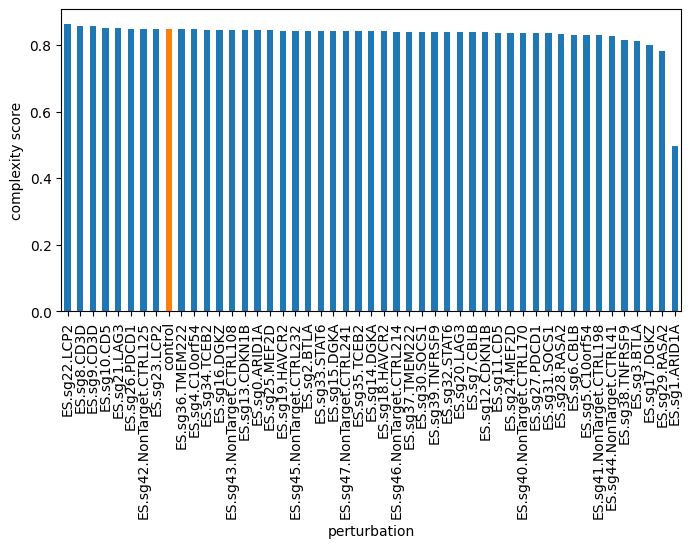

In [33]:
pl.figure(dpi=100, figsize=[8,4])
ar = compute_complexity_score(df, plot=True, show=True)